In [1]:
# from nnAudio import Spectrogram
import sys
sys.path.insert(0,'../Installation/nnAudio')
import Spectrogram
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from helperfunctions import get_dummy_dataset

from sklearn.model_selection import train_test_split
import torch
import torchvision

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
X, Y = get_dummy_dataset()

100%|██████████| 10925/10925 [00:38<00:00, 280.31it/s]


In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y.reshape(-1,1), test_size=0.2, random_state=101)

In [4]:
trainset = torch.utils.data.TensorDataset(torch.tensor(X_train, device='cpu'), torch.tensor(Y_train, device='cpu'))
testset = torch.utils.data.TensorDataset(torch.tensor(X_test, device='cpu'), torch.tensor(Y_test, device='cpu'))

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512)
testloader = torch.utils.data.DataLoader(testset, batch_size=512)

In [29]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.cqt = Spectrogram.CQT1992v2(sr=44100, hop_length=512, fmin=200,
                                     n_bins=82, bins_per_octave=12,
                                     norm=1, window='hann',
                                     center=True, pad_mode='constant', trainable=False)
#         torch.nn.init.xavier_uniform_(self.mel.mel_basis)
        
        self.regressor = torch.nn.Linear(82*18,1)

    def forward(self, x):
        x = self.cqt(x)
#         print(x.shape)
        x = x.view(x.data.size()[0], 82*18)
        x = self.regressor(x)
        return torch.sigmoid(x)

In [34]:
model = Model()
model.cuda()

CQT kernels created, time used = 0.0271 seconds


Model(
  (cqt): CQT1992v2()
  (regressor): Linear(in_features=1476, out_features=1, bias=True)
)

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=8e-7)
loss_function = torch.nn.MSELoss() 

# Visualizing Original Weights

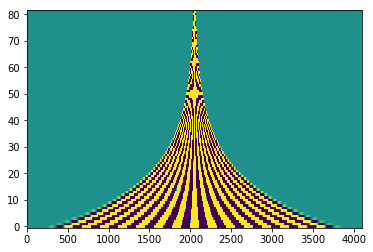

In [36]:
original_basis = model.cqt.cqt_kernels_real.cpu().detach().numpy().squeeze(1)
original_basis2 = model.cqt.cqt_kernels_imag.cpu().detach().numpy().squeeze(1)
plt.imshow(original_basis, aspect='auto', origin='lower', vmin=-1e-5,vmax=1e-5)

# Traiing Model

In [37]:
# model.mel.mel_basis.requ

loss_train = []
loss_test = []
print("epoch\ttrain loss\ttest loss")
for e in range(60):
    loss_train_e = 0.0
    loss_test_e = 0.0

    for i, (x, y) in enumerate(trainloader):
        x = x.cuda()
        y = y.cuda()/110240 # Normalizing to labels to [0,1]
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_function(y_pred, y)
        loss.backward() # Calculating gradient
        optimizer.step() # Updating paramenters by gradient
        loss_train_e += loss.item()
        print(f"training {i}/{len(trainloader)} batches, loss = {loss.item():.6f}", end = '\r')
    loss_train.append(loss_train_e/len(trainloader))
   
    with torch.no_grad():
        for x, y in testloader:
            x = x.cuda()
            y = y.cuda()/110240
            y_pred = model(x)
            loss = loss_function(y_pred, y)
            loss_test_e +=loss.item()
        loss_test.append(loss_test_e/len(testloader))
        print(' '*100, end='\r')
        print(f"{e}\t{loss_train[-1]:.6f}\t{loss_test[-1]:.6f}")

epoch	train loss	test loss
0	0.097427	0.094930                                                                                 
1	0.094165	0.091750                                                                                 
2	0.091000	0.088663                                                                                 
3	0.087928	0.085666                                                                                 
4	0.084947	0.082757                                                                                 
5	0.082053	0.079934                                                                                 
6	0.079246	0.077195                                                                                 
7	0.076524	0.074540                                                                                 
8	0.073886	0.071966                                                                                 
9	0.071330	0.069473                                             

# Visualizing Trained Weights

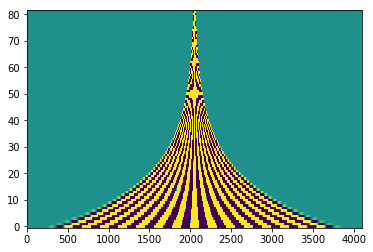

In [40]:
trained_basis = model.cqt.cqt_kernels_real.cpu().detach().numpy().squeeze(1)
trained_basis = model.cqt.cqt_kernels_imag.cpu().detach().numpy().squeeze(1)
plt.imshow(original_basis, aspect='auto', origin='lower', vmin=-1e-5,vmax=1e-5)

In [41]:
np.save('nontrainable_cqt_lin', loss_test)

# Have a closer look on the STFT basis

In [ ]:
fig, ax = plt.subplots(5,2, figsize=(12,18))
cols = ['Original', 'Trained']
for ax_idx, col in zip(ax[0], cols):
    ax_idx.set_title(col, size=16)

for i in range(5):
    ax[i,0].plot(original_basis[5*i+1])
    ax[i,1].plot(trained_basis[5*i+1])
    ax[i,0].tick_params(labelsize=12)
    ax[i,1].tick_params(labelsize=12)